In [1]:

import torch
import numpy as np
import torch.nn.functional as F


import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

from copy import deepcopy
import itertools
import random
from collections import OrderedDict


from src.model_simple import SSCNetwork
from src.utils.general import make_input, LatentSpace, get_ordered_indices, get_accuracy, test_network
from src.utils.general_old import get_selectivity, get_cos_sim_torch, get_selectivity_accuracy
from network_parameters import network_parameters



blue = '#0073B7'
yellow = '#FFD23F'
gray = '#7A7A7A'
purple = '#B05AA3'
green = '#00A651'
orange = '#F7941D'


blue_yellow = LinearSegmentedColormap.from_list(
    "blue_yellow", ["#0073B7", "#FFD23F"]
)


gray = '#C0C0C0'
purple = '#B05AA3'

gray_purple = LinearSegmentedColormap.from_list(
    "gray_purple",
    [gray , purple]
)


def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [2]:
#make network randomly project sensory input to obtain a wide distribution of selectivity in MTL-sensory
network_parameters["mtl_dense_sen_projection"] = True
network_parameters["mtl_dense_sen_size"] = 30
network_parameters["max_post_mtl_dense_sen"] = 1
network_parameters["max_pre_mtl_dense_sen"] = np.inf

In [3]:
recording_parameters = {}
recording_parameters["regions"] = ["mtl_dense", "mtl_sparse", "mtl", "ctx"]
recording_parameters["rate_activity"] = np.inf
recording_parameters["connections"] = ["ctx_mtl"]
recording_parameters["rate_connectivity"] = np.inf


input_params = {}
input_params["num_days"] = 1
input_params["day_length"] = 80
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 4


latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]


seed_everything(1)

In [4]:
original_prob_list = deepcopy(latent_specs["prob_list"])

input_params["num_days"] = 10
input_params["day_length"] = 200
input_params["mean_duration"] = 1

latent_specs["prob_list"] = [0.2 if i==0 else 0 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)

network = SSCNetwork(network_parameters, recording_parameters)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

for k in range(1, 5):
    latent_specs["prob_list"] = [0.2 if i==k else 0 for i in range(5) for j in range(5)]
    input_params["latent_space"] = LatentSpace(**latent_specs)
    input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

for k in range(5):
    latent_specs["prob_list"] = [0.2 if j==k else 0 for i in range(5) for j in range(5)]
    input_params["latent_space"] = LatentSpace(**latent_specs)
    input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)


input_params["num_days"] = 900
input_params["day_length"] = 80
input_params["mean_duration"] = 5
latent_specs["prob_list"] = original_prob_list
input_params["latent_space"] = LatentSpace(**latent_specs)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)


network.init_recordings(recording_parameters)
network.frozen = True
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = np.inf

input_params["num_days"] = 100
input, input_episodes, input_latents, network = test_network(network, input_params, sleep=False, print_rate=50)



X_ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_sparse = torch.stack(network.activity_recordings["mtl_sparse"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_dense = torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]

X_latent_A = F.one_hot(input_latents[-100:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-100:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)


selectivity_ctx, ordered_indices_ctx = get_ordered_indices(X_ctx, X_latent_AB, assembly_size=10)
selectivity_mtl_sparse, ordered_indices_mtl_sparse = get_ordered_indices(X_mtl_sparse, X_latent_AB, assembly_size=5)
selectivity_mtl_dense, ordered_indices_mtl_dense = get_ordered_indices(X_mtl_dense, X_latent_AB, assembly_size=10)

0
0
0
0
0
0
0
0
0
0
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
0
50


In [5]:
accuracy = get_accuracy(X_mtl_sparse[:, ordered_indices_mtl_sparse[:50]], input_latents.reshape((-1, 2)), assembly_size=5)


In [7]:
accuracy

tensor([0.9808, 0.8790])

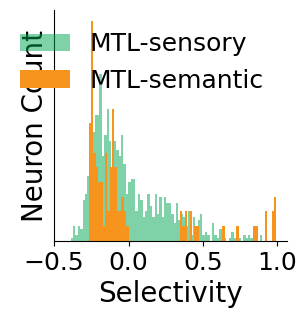

In [6]:


fig = plt.figure(figsize=(3, 3))
plt.hist(selectivity_mtl_dense[selectivity_mtl_dense != 0].flatten(), bins=80, label="MTL-sensory", alpha=0.5, color=green)
plt.hist(selectivity_mtl_sparse[selectivity_mtl_sparse != 0].flatten(), bins=80, label="MTL-semantic", alpha=1, color=orange)
plt.xlabel('Selectivity', fontsize=20)
plt.ylabel('Neuron Count', fontsize=20)
sns.despine()
plt.xticks([-0.5, 0, 0.5, 1], fontsize=18)
plt.yticks([])
plt.legend(fontsize=18, frameon=False)
plt.savefig('Figures_SVG/5c1.svg', dpi=300, transparent=True)

In [2]:
#make network randomly project sensory input to obtain a wide distribution of selectivity in MTL-sensory
network_parameters["mtl_dense_sen_projection"] = True
network_parameters["mtl_dense_sen_size"] = 30
network_parameters["max_post_mtl_dense_sen"] = 1
network_parameters["max_pre_mtl_dense_sen"] = np.inf

recording_parameters = {}
recording_parameters["regions"] = ["mtl_dense", "mtl_sparse", "mtl", "ctx", "ctx_hat"]
recording_parameters["rate_activity"] = np.inf
recording_parameters["connections"] = ["ctx_mtl"]
recording_parameters["rate_connectivity"] = np.inf



network_parameters["max_semantic_charge_replay"] = 1
network_parameters["ctx_subregions_b"] = [0.3, 0.6]


network_parameters["duration_phase_A"] = 400
network_parameters["duration_phase_B"] = 800


network_parameters["ctx_ctx_sparsity"] = 0
network_parameters["ctx_ctx_g"] = 0
network_parameters["ctx_ctx_lmbda"] = 5e-4
network_parameters["max_pre_ctx_ctx"] = 1
network_parameters["max_post_ctx_ctx"] = np.inf




In [3]:
training='blocked'
seed=0
get_network=False
seed_everything(seed)

In [4]:
original_prob_list = deepcopy(latent_specs["prob_list"])

input_params["num_days"] = 20
input_params["day_length"] = 200
input_params["mean_duration"] = 1

network = SSCNetwork(network_parameters, recording_parameters)

for k in range(5):
    latent_specs["prob_list"] = [0.2 if i==k else 0 for i in range(5) for j in range(5)]
    input_params["latent_space"] = LatentSpace(**latent_specs)
    input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

for k in range(5):
    latent_specs["prob_list"] = [0.2 if j==k else 0 for i in range(5) for j in range(5)]
    input_params["latent_space"] = LatentSpace(**latent_specs)
    input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)


0
0
0
0
0
0
0
0
0
0


In [9]:
input_params["num_days"] = 20
input_params["day_length"] = 200
input_params["mean_duration"] = 1

network.init_recordings(recording_parameters)
network.frozen = True
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = np.inf

for k in range(5):
    latent_specs["prob_list"] = [0.2 if i==k else 0 for i in range(5) for j in range(5)]
    input_params["latent_space"] = LatentSpace(**latent_specs)
    input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

for k in range(5):
    latent_specs["prob_list"] = [0.2 if j==k else 0 for i in range(5) for j in range(5)]
    input_params["latent_space"] = LatentSpace(**latent_specs)
    input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

0
0
0
0
0
0
0
0
0
0


In [ ]:
plt.imshow(network.ctx_mtl[ordered_indices_ctx[:100], :][:, ordered_indices_mtl_dense], cmap='gray')

In [7]:
accuracy_ctx

tensor([0.9761, 0.9824])

In [6]:
latent_specs["prob_list"] = original_prob_list
input_params["latent_space"] = LatentSpace(**latent_specs)

network.init_recordings(recording_parameters)
network.frozen = True
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = np.inf

input_params["num_days"] = 100
input, input_episodes, input_latents, network = test_network(network, input_params, sleep=True, print_rate=50)



X_ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_sparse = torch.stack(network.activity_recordings["mtl_sparse"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_dense = torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]

X_latent_A = F.one_hot(input_latents[-100:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-100:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)


selectivity_ctx, ordered_indices_ctx = get_ordered_indices(X_ctx, X_latent_AB, assembly_size=10)
selectivity_mtl_sparse, ordered_indices_mtl_sparse = get_ordered_indices(X_mtl_sparse, X_latent_AB, assembly_size=5)
selectivity_mtl_dense, ordered_indices_mtl_dense = get_ordered_indices(X_mtl_dense, X_latent_AB, assembly_size=10)


accuracy_mtl_sparse = get_accuracy(X_mtl_sparse[:, ordered_indices_mtl_sparse[:50]], input_latents.reshape((-1, 2)), assembly_size=5)
accuracy_ctx = get_accuracy(X_ctx[:, ordered_indices_ctx[:100]], input_latents.reshape((-1, 2)), assembly_size=10)

0
50


In [2]:
selectivity_ctx[ordered_indices_ctx].max(axis=1)[0][:52]

NameError: name 'selectivity_ctx' is not defined

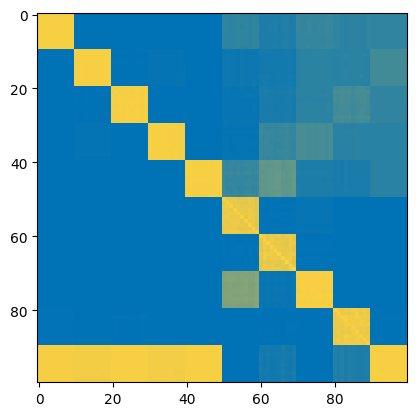

In [8]:
plt.imshow(network.ctx_ctx[ordered_indices_ctx[:100], :][:, ordered_indices_ctx[:100]], cmap=blue_yellow)

In [7]:
network.frozen = False
network.init_recordings(recording_parameters)
network.activity_recordings_rate = 1

#'''
input_params["num_days"] = 10
input_params["day_length"] = 80
input_params["mean_duration"] = 5
latent_specs["prob_list"] = original_prob_list
input_params["latent_space"] = LatentSpace(**latent_specs)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)
#'''

0


In [9]:
mtl = torch.stack(network.activity_recordings["mtl"], dim=0)[network.sleep_indices_A]
ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.sleep_indices_A]

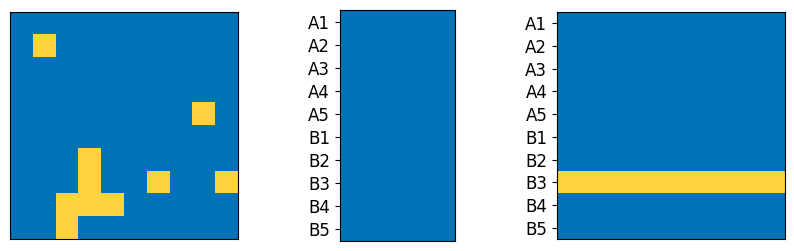

In [11]:
index = 0



fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].imshow(mtl[index, :100].reshape((-1, 10)), cmap=blue_yellow)
ax[1].imshow(mtl[index, 100:][ordered_indices_mtl_sparse[:50]].reshape((-1, 5)), cmap=blue_yellow)
ax[2].imshow(ctx[index, ordered_indices_ctx][:100].reshape((-1, 10)), cmap=blue_yellow)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].set_xticks([])


# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]


ax[1].set_yticks(positions, labels, fontsize=12)

# Example parameters
N = 10  # Total number of y-axis ticks (from 0 to N)
NA = 5   # Number of A groups
NB = 5   # Number of B groups
M = N // (NA + NB)  # Size of each group (equal-sized labels)

# Generate labels
labels_A = [f"A{i+1}" for i in range(NA)]
labels_B = [f"B{i+1}" for i in range(NB)]
labels = labels_A + labels_B
# Positions for labels (centered in each segment)
positions = [M * i for i in range(NA + NB)]

ax[2].set_yticks(positions, labels, fontsize=12)

In [ ]:
for k in range(1, 5):
    latent_specs["prob_list"] = [0.2 if i==k else 0 for i in range(5) for j in range(5)]
    input_params["latent_space"] = LatentSpace(**latent_specs)
    input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

for k in range(5):
    latent_specs["prob_list"] = [0.2 if j==k else 0 for i in range(5) for j in range(5)]
    input_params["latent_space"] = LatentSpace(**latent_specs)
    input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

In [41]:
latent_specs["prob_list"] = original_prob_list
input_params["latent_space"] = LatentSpace(**latent_specs)

network.init_recordings(recording_parameters)
network.frozen = True
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = np.inf

input_params["num_days"] = 100
input, input_episodes, input_latents, network = test_network(network, input_params, sleep=True, print_rate=50)



X_ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_sparse = torch.stack(network.activity_recordings["mtl_sparse"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_dense = torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]

X_latent_A = F.one_hot(input_latents[-100:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-100:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)


selectivity_ctx, ordered_indices_ctx = get_ordered_indices(X_ctx, X_latent_AB, assembly_size=10)
selectivity_mtl_sparse, ordered_indices_mtl_sparse = get_ordered_indices(X_mtl_sparse, X_latent_AB, assembly_size=5)
selectivity_mtl_dense, ordered_indices_mtl_dense = get_ordered_indices(X_mtl_dense, X_latent_AB, assembly_size=10)


accuracy_mtl_sparse = get_accuracy(X_mtl_sparse[:, ordered_indices_mtl_sparse[:50]], input_latents.reshape((-1, 2)), assembly_size=5)
accuracy_ctx = get_accuracy(X_ctx[:, ordered_indices_ctx[:100]], input_latents.reshape((-1, 2)), assembly_size=10)

0
50


In [13]:
network.frozen = False
network.activity_recordings_rate = np.inf

#'''
input_params["num_days"] = 900
input_params["day_length"] = 80
input_params["mean_duration"] = 5
latent_specs["prob_list"] = original_prob_list
input_params["latent_space"] = LatentSpace(**latent_specs)
input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)
#'''

latent_specs["prob_list"] = original_prob_list
input_params["latent_space"] = LatentSpace(**latent_specs)

network.init_recordings(recording_parameters)
network.frozen = True
network.activity_recordings_rate = 1
network.connectivity_recordings_rate = np.inf

input_params["num_days"] = 100
input, input_episodes, input_latents, network = test_network(network, input_params, sleep=True, print_rate=50)



X_ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_sparse = torch.stack(network.activity_recordings["mtl_sparse"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_dense = torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]

X_latent_A = F.one_hot(input_latents[-100:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-100:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)


selectivity_ctx, ordered_indices_ctx = get_ordered_indices(X_ctx, X_latent_AB, assembly_size=10)
selectivity_mtl_sparse, ordered_indices_mtl_sparse = get_ordered_indices(X_mtl_sparse, X_latent_AB, assembly_size=5)
selectivity_mtl_dense, ordered_indices_mtl_dense = get_ordered_indices(X_mtl_dense, X_latent_AB, assembly_size=10)




0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
0
50


In [20]:
accuracy_mtl_sparse = get_accuracy(X_mtl_sparse[:, ordered_indices_mtl_sparse[:50]], input_latents.reshape((-1, 2)), assembly_size=5)
accuracy_ctx = get_accuracy(X_ctx[:, ordered_indices_ctx[:100]], input_latents.reshape((-1, 2)), assembly_size=10)

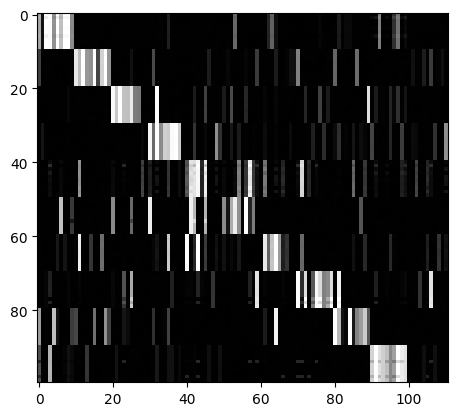

In [9]:
plt.imshow(network.ctx_mtl[ordered_indices_ctx[:100], :][:, ordered_indices_mtl_dense], cmap='gray')

In [ ]:
plt.imshow(network.ctx_mtl[ordered_indices_ctx[:100], :][:, ordered_indices_mtl_dense], cmap='gray')

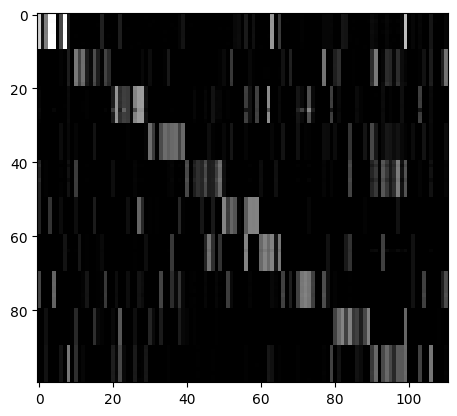

In [31]:
plt.imshow(network.ctx_mtl[ordered_indices_ctx[:100], :][:, ordered_indices_mtl_dense], cmap='gray')

In [42]:
accuracy_ctx, accuracy_mtl_sparse

(tensor([0.9729, 0.9818]), tensor([0.9699, 0.9777]))

In [15]:
accuracy_ctx, accuracy_mtl_sparse

(tensor([0.9377, 0.9538]), tensor([0.9352, 0.9525]))

NameError: name 'sns' is not defined

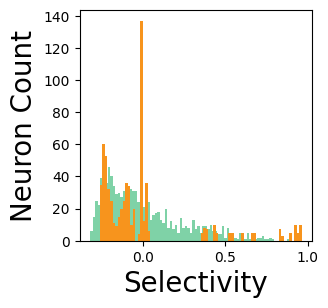

In [18]:


fig = plt.figure(figsize=(3, 3))
plt.hist(selectivity_mtl_dense[selectivity_mtl_dense != 0].flatten(), bins=80, label="MTL-sensory", alpha=0.5, color=green)
plt.hist(selectivity_mtl_sparse[selectivity_mtl_sparse != 0].flatten(), bins=80, label="MTL-semantic", alpha=1, color=orange)
plt.xlabel('Selectivity', fontsize=20)
plt.ylabel('Neuron Count', fontsize=20)
sns.despine()
plt.xticks([-0.5, 0, 0.5, 1], fontsize=18)
plt.yticks([])
plt.legend(fontsize=18, frameon=False)
plt.savefig('Figures_SVG/5c1.svg', dpi=300, transparent=True)

In [7]:

if training == 'blocked':

    original_prob_list = deepcopy(latent_specs["prob_list"])

    input_params["num_days"] = 20
    input_params["day_length"] = 200
    input_params["mean_duration"] = 1

    latent_specs["prob_list"] = [0.2 if i==0 else 0 for i in range(5) for j in range(5)]
    input_params["latent_space"] = LatentSpace(**latent_specs)

    network = SSCNetwork(network_parameters, recording_parameters)
    input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

    for k in range(1, 5):
        latent_specs["prob_list"] = [0.2 if i==k else 0 for i in range(5) for j in range(5)]
        input_params["latent_space"] = LatentSpace(**latent_specs)
        input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

    for k in range(5):
        latent_specs["prob_list"] = [0.2 if j==k else 0 for i in range(5) for j in range(5)]
        input_params["latent_space"] = LatentSpace(**latent_specs)
        input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)

    '''
    input_params["num_days"] = 900
    input_params["day_length"] = 80
    input_params["mean_duration"] = 5
    latent_specs["prob_list"] = original_prob_list
    input_params["latent_space"] = LatentSpace(**latent_specs)
    input, input_episodes, input_latents, network = test_network(network, input_params, print_rate=50)
    '''

    latent_specs["prob_list"] = original_prob_list
    input_params["latent_space"] = LatentSpace(**latent_specs)

    network.init_recordings(recording_parameters)
    network.frozen = True
    network.activity_recordings_rate = 1
    network.connectivity_recordings_rate = np.inf

    input_params["num_days"] = 100
    input, input_episodes, input_latents, network = test_network(network, input_params, sleep=True, print_rate=50)



X_ctx = torch.stack(network.activity_recordings["ctx"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_sparse = torch.stack(network.activity_recordings["mtl_sparse"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]
X_mtl_dense = torch.stack(network.activity_recordings["mtl_dense"], dim=0)[network.awake_indices][-100*input_params["day_length"]:]

X_latent_A = F.one_hot(input_latents[-100:, :, 0].long(), num_classes=latent_specs["dims"][0])
X_latent_B = F.one_hot(input_latents[-100:, :, 1].long(), num_classes=latent_specs["dims"][1])
X_latent_AB = torch.cat((X_latent_A, X_latent_B), axis=2)


selectivity_ctx, ordered_indices_ctx = get_ordered_indices(X_ctx, X_latent_AB, assembly_size=10)
selectivity_mtl_sparse, ordered_indices_mtl_sparse = get_ordered_indices(X_mtl_sparse, X_latent_AB, assembly_size=5)
selectivity_mtl_dense, ordered_indices_mtl_dense = get_ordered_indices(X_mtl_dense, X_latent_AB, assembly_size=10)


accuracy_mtl_sparse = get_accuracy(X_mtl_sparse[:, ordered_indices_mtl_sparse[:50]], input_latents.reshape((-1, 2)), assembly_size=5)
accuracy_ctx = get_accuracy(X_ctx[:, ordered_indices_ctx[:100]], input_latents.reshape((-1, 2)), assembly_size=10)

0
0
0
0
0
0
0
0
0
0
0
50


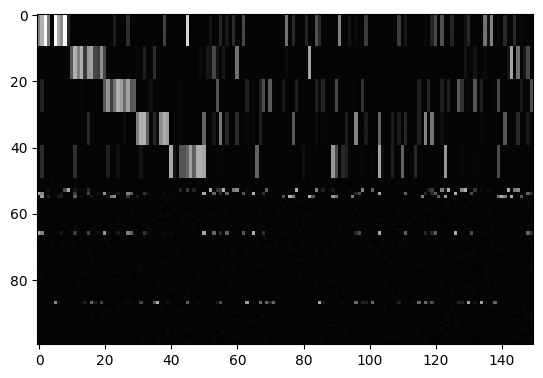

In [9]:
plt.imshow(network.ctx_mtl[ordered_indices_ctx[:100], :][:, ordered_indices_mtl_dense], cmap='gray')

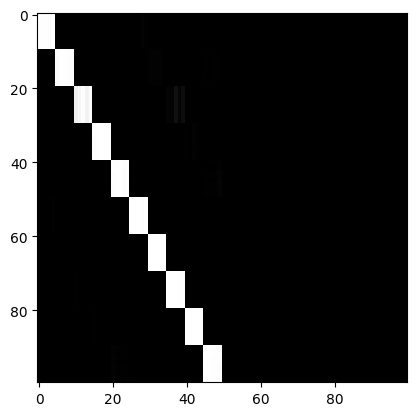

In [19]:
plt.imshow(network.ctx_mtl[ordered_indices_ctx[:100], 100:][:, ordered_indices_mtl_sparse], cmap='gray')

In [7]:
accuracy_ctx = get_accuracy(X_ctx[:, ordered_indices_ctx[:100]], input_latents.reshape((-1, 2)), assembly_size=10)

In [9]:
accuracy_ctx, accuracy_mtl_sparse

(tensor([0.8298, 0.9499]), tensor([0.8286, 0.9501]))

In [8]:
accuracy_ctx, accuracy_mtl_sparse

(tensor([0.9253, 0.9488]), tensor([0.2192, 0.2147]))

In [5]:
selectivity_ctx[ordered_indices_ctx[:100]].max(axis=1)

torch.return_types.max(
values=tensor([0.9644, 0.9666, 0.9662, 0.9661, 0.9672, 0.9623, 0.9663, 0.9642, 0.9673,
        0.9645, 0.9206, 0.9211, 0.8938, 0.9144, 0.9163, 0.9130, 0.9153, 0.9163,
        0.9142, 0.9193, 0.9119, 0.9119, 0.8066, 0.9137, 0.9082, 0.9098, 0.9071,
        0.9121, 0.9092, 0.8998, 0.9728, 0.9725, 0.9728, 0.9736, 0.9713, 0.9719,
        0.9708, 0.9726, 0.9727, 0.9727, 0.9710, 0.9809, 0.9707, 0.9697, 0.9716,
        0.9707, 0.9711, 0.9708, 0.9710, 0.9720, 0.9652, 0.9599, 0.9630, 0.9577,
        0.9608, 0.9594, 0.9625, 0.9604, 0.9591, 0.9606, 0.9835, 0.9811, 0.9821,
        0.9813, 0.9787, 0.9841, 0.9781, 0.9832, 0.9811, 0.9805, 0.9747, 0.9759,
        0.9753, 0.9740, 0.9751, 0.9746, 0.9760, 0.9759, 0.9751, 0.9754, 0.9793,
        0.9800, 0.9761, 0.9803, 0.9785, 0.9762, 0.9779, 0.9793, 0.9791, 0.9794,
        0.9934, 0.9924, 0.9926, 0.8830, 0.9920, 0.9924, 0.9929, 0.9929, 0.9926,
        0.9931]),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [7]:
selectivity_ctx[ordered_indices_ctx[:100]].argmax(axis=1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 1, 4, 3, 2, 0, 3, 3, 3, 3, 4, 0, 3, 0, 4, 2, 0, 1, 3, 0, 4, 4, 3,
        1, 3, 1, 2, 2, 2, 3, 1, 2, 4, 0, 4, 1, 2, 2, 4, 4, 3, 0, 0, 3, 4, 2, 0,
        1, 3, 4, 0])

In [8]:
import matplotlib.pyplot as plt

In [6]:
accuracy

tensor([0.2223, 0.2175])

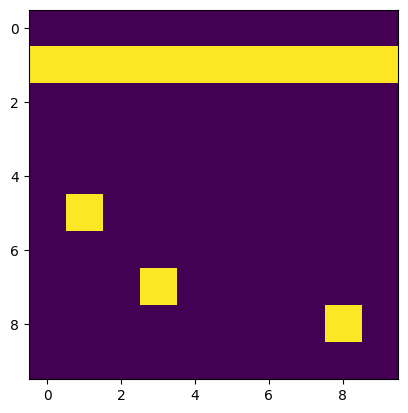

In [27]:
plt.imshow(torch.stack(network.activity_recordings["ctx"], axis=0)[network.awake_indices][-16, ordered_indices_ctx[:100]].reshape((-1, 10)))

(array([3.83000e+02, 7.42000e+02, 1.04600e+03, 1.32500e+03, 1.38900e+03,
        1.37000e+03, 1.62900e+03, 1.64800e+03, 1.74200e+03, 1.80500e+03,
        1.79000e+03, 1.71500e+03, 1.70600e+03, 1.79500e+03, 1.70300e+03,
        1.68000e+03, 1.79800e+03, 1.69900e+03, 1.73600e+03, 1.66600e+03,
        1.67400e+03, 1.77000e+03, 1.65200e+03, 1.74800e+03, 1.85700e+03,
        1.78500e+03, 1.85800e+03, 1.95100e+03, 1.93100e+03, 2.00400e+03,
        2.07400e+03, 2.00100e+03, 1.90900e+03, 1.78000e+03, 1.96900e+03,
        1.82200e+03, 1.73700e+03, 1.79700e+03, 1.78900e+03, 1.59700e+03,
        1.64100e+03, 1.55500e+03, 1.35400e+03, 1.41300e+03, 1.26300e+03,
        1.35200e+03, 1.28200e+03, 1.24500e+03, 1.15800e+03, 1.20100e+03,
        1.07700e+03, 1.04300e+03, 9.28000e+02, 8.97000e+02, 8.93000e+02,
        9.03000e+02, 9.39000e+02, 8.90000e+02, 7.88000e+02, 7.53000e+02,
        5.83000e+02, 5.84000e+02, 5.94000e+02, 5.29000e+02, 5.69000e+02,
        5.79000e+02, 5.60000e+02, 4.76000e+02, 4.75

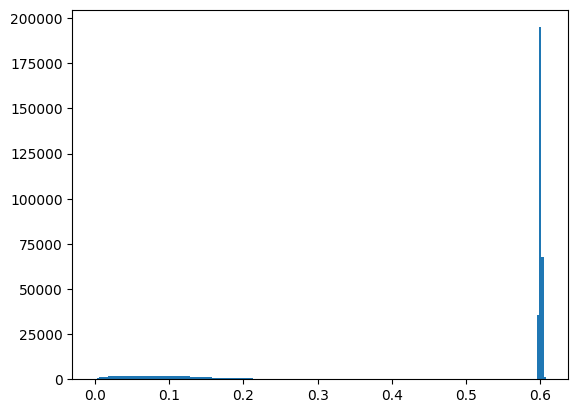

In [15]:
plt.hist(torch.stack(network.activity_recordings["ctx_hat"], axis=0)[network.sleep_indices_A].flatten(), bins=200)

In [18]:
mtl_sleep = torch.stack(network.activity_recordings["mtl_dense"], axis=0)[network.sleep_indices_A]

In [20]:
overlaps = []
for index_1, mtl_1 in enumerate(mtl_sleep):
    for index_2, mtl_2 in enumerate(mtl_sleep):
        if index_1 != index_2:
            overlaps.append(get_cos_sim_torch(mtl_1, mtl_2))

(array([3.29442e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 4.08490e+05,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 2.01246e+05, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 5.15500e+04, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 7.57400e+03, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

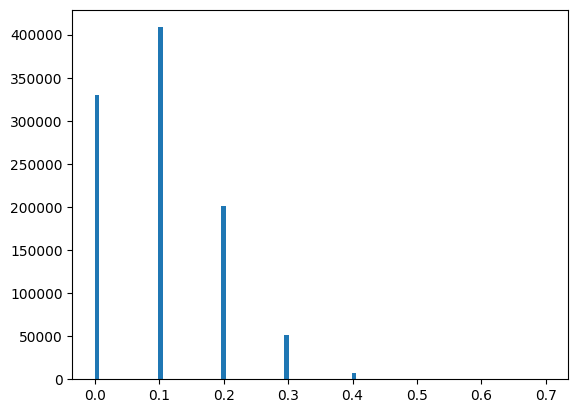

In [22]:
plt.hist(overlaps, bins=100)

In [24]:
torch.max(torch.tensor(overlaps))

tensor(0.7000)

In [2]:
from src.model import SSCNetwork
#from src.model_simple import SSCNetwork
from src.utils.general import make_input, LatentSpace, get_ordered_indices

In [3]:
network_parameters = {}

network_parameters["hebbian_filter"] = False

network_parameters["duration_phase_A"] = 1000
network_parameters["duration_phase_B"] = 1500

network_parameters["sleep_duration_A"] = 10
network_parameters["sleep_duration_B"] = 10
network_parameters["reset_dayly"] = True

network_parameters["regions"] = ["sen", "mtl_sparse", "mtl_dense", "mtl", "ctx"]

network_parameters["mtl_pattern_complete_iterations"] = 10
network_parameters["mtl_dense_pattern_complete_iterations"] = 10
network_parameters["mtl_sparse_pattern_complete_iterations"] = 10
network_parameters["ctx_pattern_complete_iterations"] = 10
network_parameters["mtl_generate_pattern_complete_iterations"] = 10

network_parameters["max_semantic_charge"] = 2

network_parameters["sen_num_subregions"] = 1
network_parameters["sen_size_subregions"] = torch.tensor([100])
network_parameters["sen_sparsity"] = torch.tensor([0.2])
network_parameters["sen_sparsity_sleep"] = torch.tensor([0.2])

network_parameters["ctx_num_subregions"] = 2
network_parameters["ctx_size_subregions"] =  torch.tensor([100, 250])
network_parameters["ctx_sparsity"] = torch.tensor([0.2, 1/25])
network_parameters["ctx_sparsity_sleep"] = torch.tensor([0.1, 1/25])

network_parameters["mtl_num_subregions"] = 2
network_parameters["mtl_size_subregions"] =  torch.tensor([100, 100])
network_parameters["mtl_sparsity"] = torch.tensor([0.2, 0.1])
network_parameters["mtl_sparsity_sleep"] = torch.tensor([0.1, 0.05])

network_parameters["mtl_dense_num_subregions"] = 1
network_parameters["mtl_dense_size_subregions"] = torch.tensor([100])
network_parameters["mtl_dense_sparsity"] = torch.tensor([0.2])
network_parameters["mtl_dense_sparsity_sleep"] = torch.tensor([0.1])

network_parameters["mtl_sparse_num_subregions"] = 1
network_parameters["mtl_sparse_size_subregions"] = torch.tensor([100])
network_parameters["mtl_sparse_sparsity"] = torch.tensor([0.1])
network_parameters["mtl_sparse_sparsity_sleep"] = torch.tensor([0.05])

network_parameters["mtl_dense_sen_projection"] = False
network_parameters["mtl_dense_sen_sparsity"] = 0.5

network_parameters["ctx_mtl_quick_lmbda"] = 1e-2
network_parameters["max_pre_ctx_mtl_quick"] = np.inf
network_parameters["max_post_ctx_mtl_quick"] = 1

network_parameters["ctx_mtl_sparsity"] = 0.5
network_parameters["ctx_mtl_mean"] = 0.03
network_parameters["ctx_mtl_std"] = 0
network_parameters["ctx_mtl_lmbda"] = 5e-4
network_parameters["ctx_mtl_size"] = 2
network_parameters["max_pre_ctx_mtl"] = np.inf
network_parameters["max_post_ctx_mtl"] = 1

network_parameters["ctx_mtl_sparse_mean"] = 0.07
network_parameters["ctx_mtl_sparse_std"] = 0.001
network_parameters["ctx_mtl_sparse_lmbda"] = 5e-4
network_parameters["max_pre_ctx_mtl_sparse"] = np.inf
network_parameters["max_post_ctx_mtl_sparse"] = 1

network_parameters["ctx_mtl_dense_sparsity"] = 0.5
network_parameters["ctx_mtl_dense_g"] = 0.01

network_parameters["mtl_mtl_lmbda"] = 5e-3
network_parameters["max_pre_mtl_mtl"] = 1
network_parameters["max_post_mtl_mtl"] = np.inf

network_parameters["mtl_dense_mtl_dense_lmbda"] = 5e-3
network_parameters["max_pre_mtl_dense_mtl_dense"] = 1
network_parameters["max_post_mtl_dense_mtl_dense"] = np.inf

network_parameters["mtl_sparse_mtl_sparse_lmbda"] = 5e-3
network_parameters["max_pre_mtl_sparse_mtl_sparse"] = 1
network_parameters["max_post_mtl_sparse_mtl_sparse"] = np.inf

network_parameters["ctx_ctx_sparsity"] = 0.05
network_parameters["ctx_ctx_g"] = 1e-4
network_parameters["ctx_ctx_lmbda"] = 5e-4
network_parameters["max_pre_ctx_ctx"] = 1
network_parameters["max_post_ctx_ctx"] = np.inf

network_parameters["mtl_sparse_ctx_mean"] = 0.03
network_parameters["mtl_sparse_ctx_std"] = 0.001
network_parameters["mtl_sparse_ctx_lmbda"] = 5e-3
network_parameters["max_pre_mtl_sparse_ctx"] = np.inf
network_parameters["max_post_mtl_sparse_ctx"] = 1


recording_parameters = {}
recording_parameters["regions"] = ["mtl_dense", "mtl_sparse", "mtl", "ctx", "ctx_hat"]
recording_parameters["rate_activity"] = 1
recording_parameters["connections"] = ["ctx_mtl"]

#recording_parameters["rate_connectivity"] = 1
recording_parameters["rate_connectivity"] = 1

In [4]:
input_params = {}
input_params["num_days"] = 1000
input_params["day_length"] = 40
input_params["mean_duration"] = 5
input_params["fixed_duration"] = True
input_params["num_swaps"] = 0

latent_specs = {}
latent_specs["num"] = 2
latent_specs["total_sizes"] = [50, 50]
latent_specs["act_sizes"] = [10, 10]
latent_specs["dims"] = [5, 5]

In [7]:
latent_specs["prob_list"] = [0.5/5 if i==j else 0.5/20 for i in range(5) for j in range(5)]
input_params["latent_space"] = LatentSpace(**latent_specs)



input, input_episodes, input_latents = make_input(**input_params)